In [ ]:
%cd drive/MyDrive/pythonlibs

/content/drive/MyDrive/pythonlibs


In [ ]:
! pip install wandb
! pip install xgboost

     |████████████████████████████████| 1.8 MB 15.4 MB/s 
     |████████████████████████████████| 181 kB 73.9 MB/s 
     |████████████████████████████████| 144 kB 75.7 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=460d03c0461303deb7dc0c33efccb45764c2a433209ddc14f232b36ce142db3f
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
import wandb
wandb.init(project="NHANES")
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

import utils
import models
import algorithm
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from torch.utils.data import TensorDataset, DataLoader

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
X = np.fromfile('../nhanes_data/data_onehot_encoded_outer.dat').reshape(11108,-1)

y = np.fromfile('../nhanes_data/label.dat')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train = torch.Tensor(X_train).to(device)
X_test = torch.Tensor(X_test).to(device)
y_train = torch.Tensor(y_train).to(device)
y_test = torch.Tensor(y_test).to(device)

In [ ]:
"""
from absl import app, flags

FLAGS = flags.FLAGS

flags.DEFINE_integer('n_layers', 1, "# of layers of your FCN")
flags.DEFINE_integer('n_hidden_units', 100, "# of hidden units of your FCN: they are all identical")
flags.DEFINE_float('lr', 1e-4, "learning rate")
flags.DEFINE_integer('n_epochs', 1000, "# of epochs")
flags.DEFINE_string('lr_scheduler', "step", "either step(step decay) or None")

"""
hyperparams = {'n_layers' : 5, 
               'n_hidden_units' : 50,
               'batch_size' : 256,
               'optimizer' : "adam", # "adam" or "sgd"
               'lr' : 1e-4,
               'n_epochs' : 10000,
               'lr_scheduler' : "exp", # "step" or "exp" or "none"
               'lr_scheduler_step_size' : 50,
               'lr_scheduler_gamma' : 0.2
               }
print(hyperparams)

{'n_layers': 5, 'n_hidden_units': 50, 'batch_size': 256, 'optimizer': 'adam', 'lr': 0.0001, 'n_epochs': 10000, 'lr_scheduler': 'exp', 'lr_scheduler_step_size': 50, 'lr_scheduler_gamma': 0.2}


In [ ]:
train_set = TensorDataset(X_train, y_train)
test_set = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_set, shuffle=True, batch_size=hyperparams["batch_size"])

In [ ]:
net = models.Classifier(n_layers=hyperparams["n_layers"], 
                        n_inputs=X_train.shape[1], 
                        n_hidden_units= hyperparams["n_hidden_units"], 
                        n_classes=2).to(device)
if hyperparams["optimizer"] == "adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=hyperparams["lr"])
if hyperparams["optimizer"] == "sgd":
    optimizer = torch.optim.SGD(net.parameters(), lr=hyperparams["lr"])
if hyperparams["lr_scheduler"] == "step":
    lr_scheduler = StepLR(optimizer, step_size=hyperparams["lr_scheduler_step_size"], gamma=hyperparams["lr_scheduler_gamma"])
if hyperparams["lr_scheduler"] == "exp":
    lr_scheduler = ExponentialLR(optimizer, gamma=hyperparams["lr_scheduler_gamma"])
else: 
    lr_scheduler = None

In [ ]:
accs, costs, net = algorithm.train(train_loader, X_test, 
                                   y_test, net, optimizer, 
                                   lr_scheduler=lr_scheduler, 
                                   device=device, 
                                   n_epochs=hyperparams["n_epochs"])

wandb.log({"train accuracy" : accs[0],
           "test accuracy" : accs[1]})

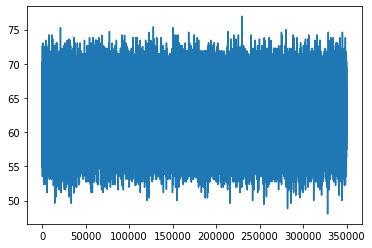

In [ ]:
plt.plot(range(len(costs)), costs)

In [ ]:
PATH= "../ml_models/onehot/lyrs{}_hidden{}_bs{}_optimizer{}_lr{}_ep{}_lrsch{}_lrstp{}_lrgma{}.pt".format(hyperparams["n_layers"],
                                                                          hyperparams["n_hidden_units"],
                                                                          hyperparams["batch_size"],
                                                                          hyperparams["optimizer"],
                                                                          hyperparams["lr"],
                                                                          hyperparams["n_epochs"],
                                                                          hyperparams["lr_scheduler"],
                                                                          hyperparams["lr_scheduler_step_size"],
                                                                          hyperparams["lr_scheduler_gamma"])
torch.save(net.state_dict(), PATH)